## INSY 695 - Assignment 3 - CausalML
### Eunice Worifah


<br>

<ins>**Overview:**</ins> Causality tries to answer the questions of ‘what if’. Statistical inference and machine learning techniques focus on how changes in X associates with changes in Y; however, causal inference focuses on understanding whether X has a causal effect on Y, i.e. whether changes in X would cause changes in Y. 

In this exercise, I will be using a dataset which predicts the Customer Lifetime Value of clients of an auto insurance company. 

My variable of focus is: **Sales Channel - Agent**. Does acquiring a customer through an Agent (versus any other Sales Channel) have a causal effect on the Customer Lifetime Value? 

<ins>**Hypothesis:**</ins> My hypothesis is that going through a Sales Agent will have a postive effect on the Customer Lifetime Value. From a qualitative perspective, this may be because of the added 'human' value and the increased level of customer service which the client receives. Usually, I would expect this personal touch to increase the level of customer satisfaction which would increase their willingness to opt for more premium packages and increase the length of time they stay on their insurance policy; hence, increasing their Customer Lifetime Value. 

I will be using the **CausalML** package to test this hypothesis. 
(Please note, I also used the *DoWhy* package at the end of the script as a learning exercise and compared the results).

In [ ]:
#!pip install causalml 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (10,5)

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
import causalml
print(causalml.__version__)

0.9.0


In [4]:
url = "https://raw.githubusercontent.com/euniceworifah/Academic-Projects/main/Customer%20Lifetime%20Value%20-%20Predictive%20Analysis/CLVdata2.csv"
clv = pd.read_csv(url)

In [5]:
clv.head()

,State,Customer Lifetime Value,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,Basic,Bachelor,Employed,F,56274.0,Suburban,Married,69,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,Extended,Bachelor,Unemployed,F,NaN,Suburban,Single,94,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,Premium,Bachelor,Employed,F,48767.0,Suburban,Married,108,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,Basic,Bachelor,Unemployed,M,NaN,Suburban,Married,106,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,Basic,Bachelor,Employed,M,43836.0,Rural,Single,73,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [6]:
#fill missing values with zero
clv=clv.fillna(0)

#dummify the categorical variables
clv1 = pd.get_dummies(clv, columns = ['State','Coverage','Education','EmploymentStatus','Gender','Location Code','Marital Status','Policy Type','Policy','Renew Offer Type','Sales Channel','Vehicle Class','Vehicle Size'])
clv1.head()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_Arizona,State_California,...,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small
0,2763.519279,56274.0,69,32,5,0,1,384.811147,0,0,...,0,0,0,0,0,0,1,0,1,0
1,6979.535903,0.0,94,13,42,0,8,1131.464935,1,0,...,0,1,0,0,0,0,0,0,1,0
2,12887.431650,48767.0,108,18,38,0,2,566.472247,0,0,...,0,0,0,0,0,0,1,0,1,0
3,7645.861827,0.0,106,18,65,0,7,529.881344,0,1,...,0,0,0,0,1,0,0,0,1,0
4,2813.692575,43836.0,73,12,44,0,1,138.130879,0,0,...,0,1,0,0,0,0,0,0,1,0


In [7]:
y = clv1['Customer Lifetime Value']
treatment = clv1['Sales Channel_Agent']

#confounding variables
X = clv1[['Monthly Premium Auto','Number of Policies', 'Coverage_Premium','Policy Type_Personal Auto','Renew Offer Type_Offer1','Sales Channel_Web','Total Claim Amount']]


## CausalML

### ATE - Average Treatment Effect

In [9]:
#S-Learner using LinearRegression
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

#------------
#T-Learner using XGB
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

#Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
te, lb, ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Average Treatment Effect (BaseTRegressor using LinearRegression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

#-------------
nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

#--------------
# X-Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
te, lb, ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Average Treatment Effect (BaseXRegressor using LinearRegression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

#--------------
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
te, lb, ub = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using LinearRegression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): -275.16 (-560.01, 9.70)
Average Treatment Effect (XGBoost): -47.75 (-156.52, 61.01)
Average Treatment Effect (BaseTRegressor using LinearRegression): -222.89 (-487.21, 41.44)
Average Treatment Effect (Neural Network (MLP)): 341.67 (77.04, 606.30)
Average Treatment Effect (BaseXRegressor using XGBoost): -38.45 (-138.36, 61.46)
Average Treatment Effect (BaseXRegressor using LinearRegression): -244.04 (-508.33, 20.25)
Average Treatment Effect (BaseRRegressor using XGBoost): -24.27 (-26.17, -22.36)
Average Treatment Effect (BaseRRegressor using LinearRegression): -186.29 (-189.06, -183.51)


**INTERPRETATION OF *ATE* OUTPUT:**

The ATE measures the difference in mean (average) outcomes between units assigned to the treatment and units assigned to the control (Treatment = Agent, Control = Other Sales Channels). A positive ATE suggests that the treatment increases the outcome.  A negative ATE suggests that the treatment decreases the outcome.  

The *S-Learner* algorithm estimates the target variable using all the covariate features and treatment indicator, without giving the treatment indicator any special role. 

The *T-Learner* estimates the response functions separately for the treatment and control populations.

When real-world data contains more control group than treatment group, the likelihood of overfitting the treatment group when using T-learner is high. *X-learner* tries to avoid this by using information from the control group to derive better estimators for the treatment group and vice versa.

The *R-Learner* provides a general framework to estimate the heterogeneous treatment effect

Source: https://medium.com/data-science-at-microsoft/causal-inference-part-2-of-3-selecting-algorithms-a966f8228a2d

### CATE - Conditional Average Treatment Effect

In [10]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner without propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y)

# R Learner without propensity score input
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y)

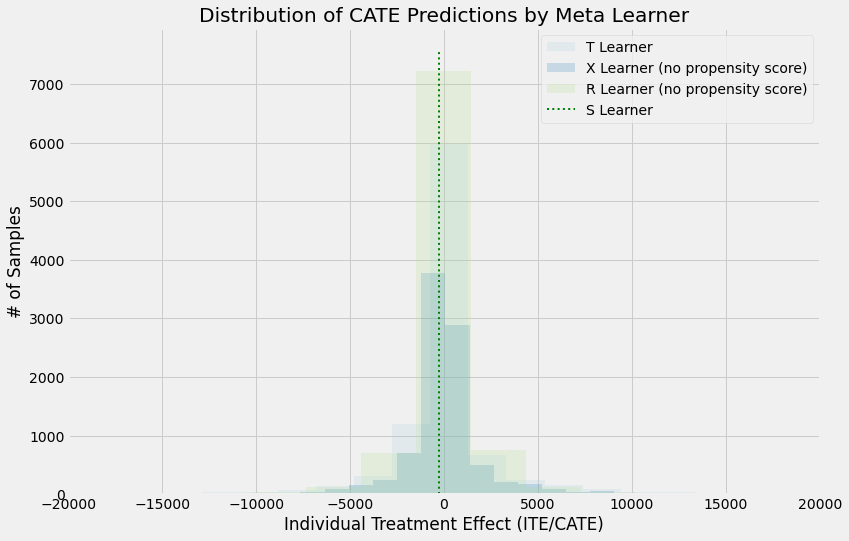

In [11]:
alpha=0.2
bins=40
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.xlim(-20000, 20000)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

### Feature Importance

Text(0.5, 1.0, 'Feature Importance - T-Learner')

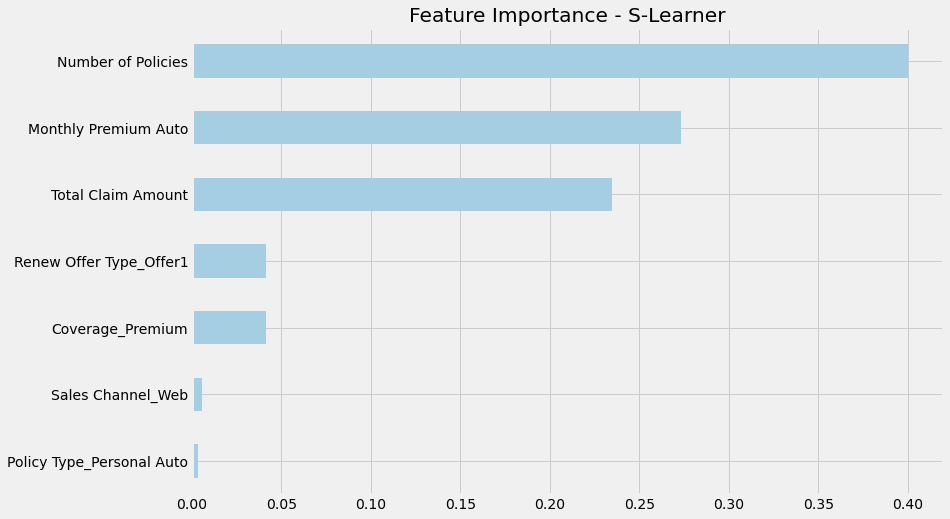

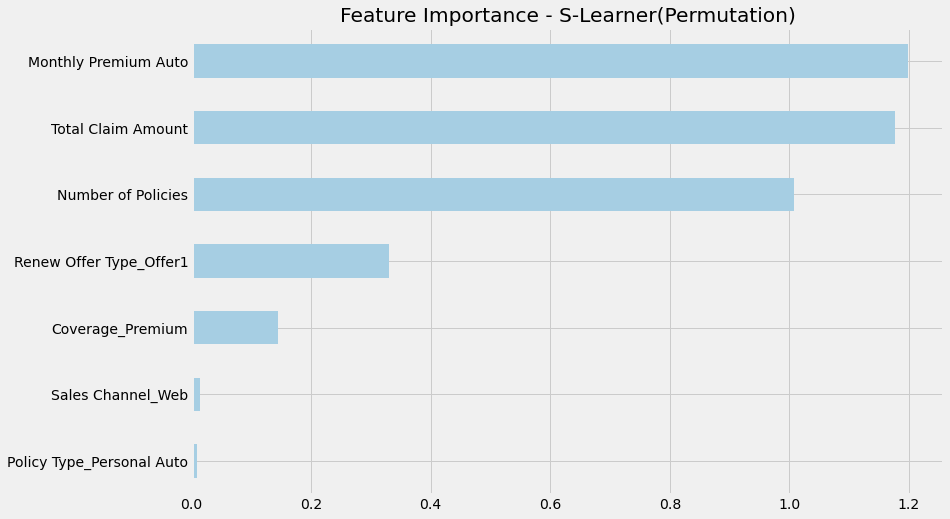

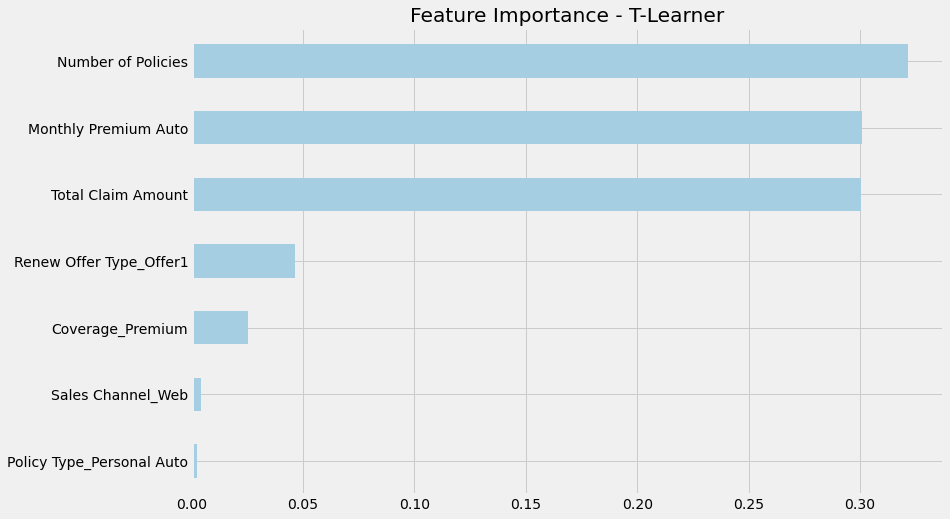

In [12]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in treatment]) # customize treatment/control names
feature_names = ['Monthly Premium Auto','Number of Policies', 'Coverage_Premium','Policy Type_Personal Auto','Renew Offer Type_Offer1','Sales Channel_Web','Total Claim Amount']

model_tau = LGBMRegressor(importance_type='gain')
#model_tau_feature = RandomForestRegressor()  # specify model for model_tau_feature

#S-Learner
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)
slearner_tau = slearner.fit_predict(X, w_multi, y)
slearner.get_importance(X=X, tau=slearner_tau,
                        normalize=True, method='auto', features=feature_names)

# Plot features importance
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='auto', features=feature_names)
plt.title('Feature Importance - S-Learner')

# Using eli5's PermutationImportance
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='permutation', features=feature_names)
plt.title('Feature Importance - S-Learner(Permutation)')

#-----------

#T-Learner
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)
tlearner_tau = tlearner.fit_predict(X, w_multi, y)
tlearner.get_importance(X=X, tau=tlearner_tau, 
                        normalize=True, method='auto', features=feature_names)

#Plot features importance
tlearner.plot_importance(X=X, tau=tlearner_tau, normalize=True, method='auto', features=feature_names)
plt.title('Feature Importance - T-Learner')



### Sharply Values - Summary Plots

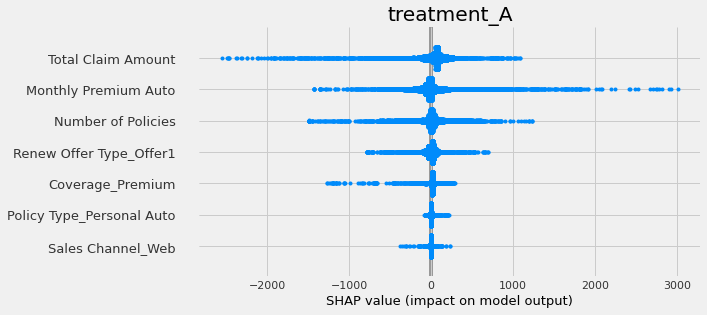

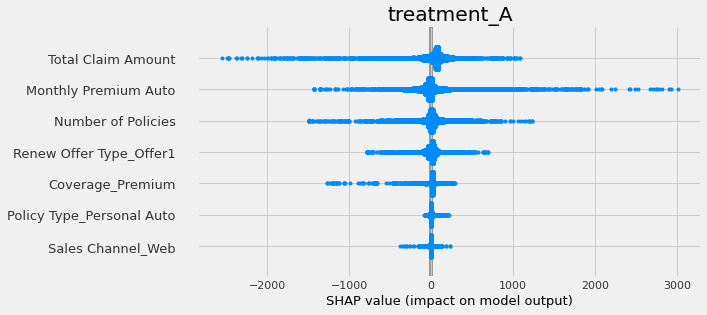

In [20]:
#S-Learner
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau,features=feature_names)

# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features=feature_names)

### Dependence Plot with Interaction

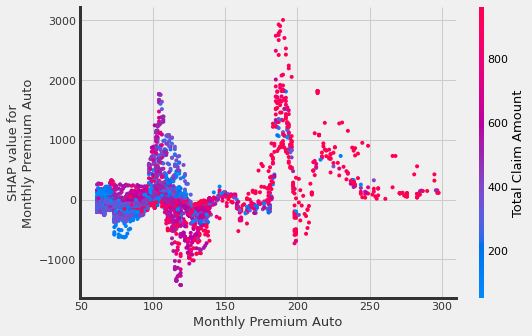

In [19]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='Monthly Premium Auto',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

**INTERPRETATION OF:** 

*SHAP VALUES* - The goal of SHAP is to explain the prediction of an instance X by computing the contribution of each feature to the prediction.

*Feature Importance Plots* - Features with large absolute SHAP values are important. The plot sorts the features by decreasing importance.

*Summary Plots* - The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.

*SHAP Dependence Plot with Interaction* - The interaction effect is the additional combined feature effect after accounting for the individual feature effects.

Source: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

### Conclusion

*ATE:* In this case, when experimenting with all meta-learners and algorithms, the ATE is always negative, meaning that acquiring a customer via a Sales Agent has a negative effect on the Customer Lifetime Value. This is surprising, as it refutes my initial hypothesis. For instance, using S-Learner, the ATE was -275...this means...

*Feature Importance:* The Number of Policies seems to be the most important feature (although using S-Learner with permuations, Monthly Premium Auto is the most important feature). The Number of Policies changes the predicted Customer Lifetime Value on average by 0/4 percentage points (0.40 on x-axis).

*Summary Plots:*  Low number of years on hormonal contraceptives reduce the predicted cancer risk, a large number of years increases the risk. Your regular reminder: All effects describe the behavior of the model and are not necessarily causal in the real world.

*SHAP Dependence Plot with Interaction:* Monthly Premium Auto interacts with Total Claim Amount. In cases close to Low Monthly Premium Auto (50-110), the increase of Total Claim Amount increases the predicted Customer Lifetime Value. Between Monthly Premium Auto of 110-160, a higher Total Claim Amount decresease the predictive CLV. However, for higher Monthly Premium Autos 160+, a high Total Claim Amount actually increases the predicted CLV. Please note that this is not a causal model. Effects might be due to confounders.




### END - THANK YOU!

## EXTRA

### DoWhy

In [85]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import dowhy.api

In [86]:
# define treatment and target

model=CausalModel(
        data = clv1,
        treatment=['Sales Channel_Agent'],
        outcome="Customer Lifetime Value",
        common_causes = ['Number of Policies','Monthly Premium Auto', 'Coverage_Premium','Policy Type_Personal Auto','Renew Offer Type_Offer1','Sales Channel_Web','Total Claim Amount'])


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Sales Channel_Agent'] on outcome ['Customer Lifetime Value']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


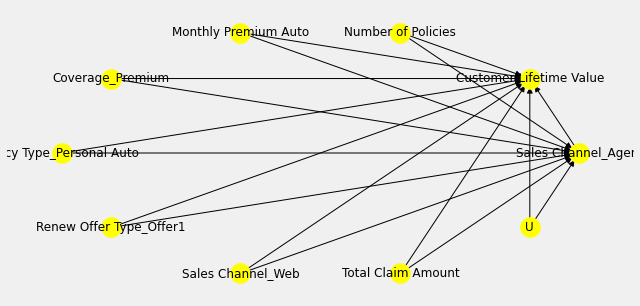

In [96]:
model.view_model(layout="dot")

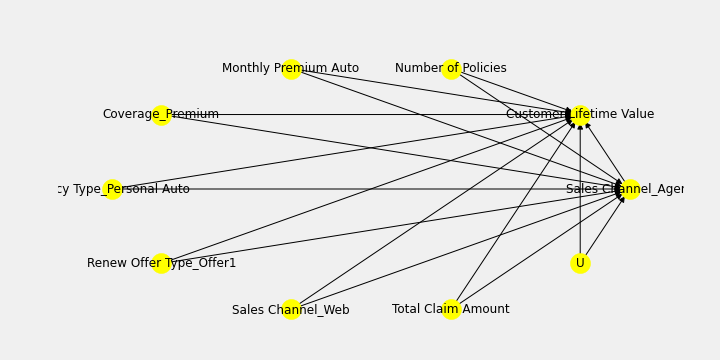

In [97]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### Identification

In [89]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
          d                                                                   
──────────────────────(Expectation(Customer Lifetime Value|Policy Type_Persona
d[Sales Channel_Agent]                                                        

                                                                              
l Auto,Sales Channel_Web,Coverage_Premium,Total Claim Amount,Renew Offer Type_
                                                                              

                                                
Offer1,Monthly Premium Auto,Number of Policies))
                                                
Estimand assumption 1, Unconfoundedness: If U→{Sales Channel_Agent} and U→Customer Lifetime Value then P(Customer Lifetime Value|Sales Channel_Agent,Policy Type_Personal Auto,Sales Channel_Web,Coverage_Premium,Total Claim Amount,Renew Offer Type_Offer1,Monthly Premium A

In [90]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True)
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:b: Customer Lifetime Value~Sales Channel_Agent+Policy Type_Personal Auto+Sales Channel_Web+Coverage_Premium+Total Claim Amount+Renew Offer Type_Offer1+Monthly Premium Auto+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Customer Lifetime Value~Sales Channel_Agent+Policy Type_Personal Auto+Sales Channel_Web+Coverage_Premium+Total Claim Amount+Renew Offer Type_Offer1+Monthly Premium Auto+Number of Policies
Target units: ate

## Estimate
Mean value: -275.15587146215876
p-value: [0.05590323]

Causal Estimate is -275.15587146215876


### Refuting the estimate

Adding a random common cause variable

In [91]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:b: Customer Lifetime Value~Sales Channel_Agent+Policy Type_Personal Auto+Sales Channel_Web+Coverage_Premium+Total Claim Amount+Renew Offer Type_Offer1+Monthly Premium Auto+Number of Policies+w_random
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add a Random Common Cause
Estimated effect:-275.15587146215876
New effect:-275.3773394582986



Adding an unobserved common cause variable

In [92]:
res_unobserved=model.refute_estimate(identified_estimand, causal_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:b: Customer Lifetime Value~Sales Channel_Agent+Policy Type_Personal Auto+Sales Channel_Web+Coverage_Premium+Total Claim Amount+Renew Offer Type_Offer1+Monthly Premium Auto+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add an Unobserved Common Cause
Estimated effect:-275.15587146215876
New effect:-301.7849848631231



Replacing treatment with a random (placebo) variable

In [93]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:b: Customer Lifetime Value~placebo+Policy Type_Personal Auto+Sales Channel_Web+Coverage_Premium+Total Claim Amount+Renew Offer Type_Offer1+Monthly Premium Auto+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Customer Lifetime Value~placebo+Policy Type_Personal Auto+Sales Channel_Web+Coverage_Premium+Total Claim Amount+Renew Offer Type_Offer1+Monthly Premium Auto+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Customer Lifetime Value~placebo+Policy Type_Personal Auto+Sales Channel_Web+Coverage_Premium+Total Claim Amount+Renew Offer Type_Offer1+Monthly Premium Auto+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Customer Lifetime Value~placebo

Refute: Use a Placebo Treatment
Estimated effect:-275.15587146215876
New effect:5.998693503365703
p value:0.49



In [ ]:

X = df_enc[feats]
effects = dict()

for i in to_test:
    model = CausalModel(
        data = df_enc,
        treatment = i,
        outcome = 'Attrition',
        common_causes = list(X.drop(i, axis = 'columns').columns)
    )
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                    test_significance = True)
    
    effects[i] = estimate.value

### Insights: 

We can observe that the ATE value (-275) is similar to the S-Learner value. P-value is greater than 0.05, which means that the ATE of 'Sales Channel_Agent' on the outcome (CLV) is not significant.